In [1]:
import os
import glob
import json
import yaml
import numpy as np
import torch
import argparse

import sys
from pathlib import Path
abs_path = str(Path.cwd().parents[0].absolute())
sys.path+=[abs_path, f'{abs_path}/utils']
from evaluation import Options, Trainer

import trimesh
from utils import ICT_face_model, YamlArgParser
from utils.matplotlib_rnd import (
    render_mesh_diff,
    plot_image_array
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
config = f'{abs_path}/config/train.yml'
opts_yaml = yaml.load(open(config), Loader=yaml.FullLoader)
opts = argparse.Namespace(**opts_yaml)

opts.NFR = False
opts.dec_type = 'disp'
opts.ckpt = '../ckpts/2024-08-18-23-32-29-all' ## ------> load checkpoint
opts.design = 'new2'

opts.device="cuda:0"

opts.data_rand_trans=False
opts.data_rand_scale=False
opts.learn_rig_emb=False
opts.use_decimate = False
opts.stage1 = True
opts.scale_exp = 1.0

trainer = Trainer(opts)

[DiffusionNet] warning: no pre_computes provided!
[DiffusionNet] warning: no pre_computes provided!
[DiffusionNet] warning: no pre_computes provided!
===========< NFS >===========
[mesh_decoder]: 	600835
[mesh_id_encoder]: 	1906560
[mesh_exp_encoder]: 	1906560
[mesh_seg_encoder]: 	1878804
-------------------------------
[total]: 	6831191
Loading... ../ckpts/2024-08-18-23-32-29-all/model_best.pth


(11248, 3)


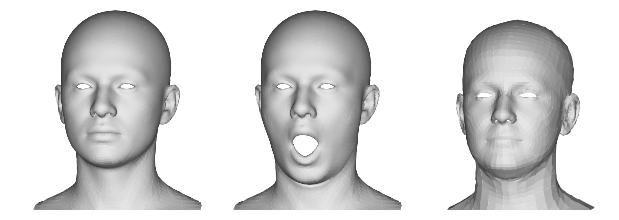

In [3]:
## full head
ict_face_model = ICT_face_model()
ict_tri = ict_face_model.get_mesh()

## flame
flame_tri = trimesh.load(f'{abs_path}/test-mesh/flame_final_transformed.obj', process=False, maintain_order=True)


## ICT random expression
bs_coeff = np.eye(53)[26]
vertices = torch.from_numpy(ict_tri.vertices + ict_face_model.get_exp_disp(bs_coeff))
src_mesh = ict_tri
tgt_mesh = flame_tri


print(ict_tri.vertices.shape)

M_SCALE = 0.68
v_list=[ ict_tri.vertices * M_SCALE, vertices[0] * M_SCALE, flame_tri.vertices * M_SCALE ]
f_list=[ ict_tri.faces, ict_tri.faces, flame_tri.faces ]
SIZE=2

plot_image_array(
    v_list, f_list,
    rot_list=[[0,-10,0]]*len(v_list), 
    size=SIZE, bg_black=False, mode='shade', 
    logdir=f"_tmp/train", 
    name=f"test", save=False
)

In [4]:
pred_outputs = trainer.model.inference(
    gt_vertices=vertices, 
    src_mesh=src_mesh, 
    tgt_mesh=tgt_mesh
)

 source neutral 	|	 source expression 	|	 target neutral 	|	 target expression


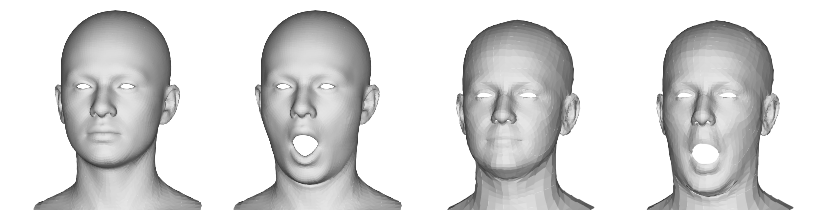

In [5]:
v_list=[ ict_tri.vertices * M_SCALE, vertices[0] * M_SCALE, flame_tri.vertices * M_SCALE, pred_outputs.detach().cpu().numpy()[0] * M_SCALE ]
f_list=[ ict_tri.faces, ict_tri.faces, flame_tri.faces, flame_tri.faces ]

print(' source neutral \t|\t source expression \t|\t target neutral \t|\t target expression')
plot_image_array(
    v_list, f_list,
    rot_list=[[0,-10,0]]*len(v_list), 
    size=SIZE, bg_black=False, mode='shade', 
    logdir=f"_tmp/train", 
    name=f"test", save=False
)